[View in Colaboratory](https://colab.research.google.com/github/You-Your-Yu/machine-learning-assignment/blob/master/Shimosaka_mid_1515309.ipynb)

# Problem 3

## Dataset 2

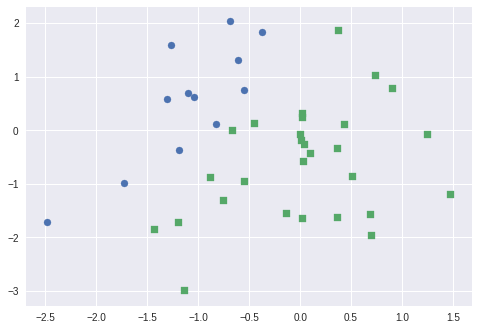

In [2]:
import numpy as np
import matplotlib.pyplot as plt

def create_dataset2(n=40, bias=False,  sd=100):
    np.random.seed(sd)
    omega = np.random.randn(1, 1)
    noise = 0.8 * np.random.randn(n, 1)
    # x: n*2行列
    X = np.random.randn(n, 2)
    # y: n*1行列
    y = 2 * ((omega * X[:,0] + X[:,1] + noise) > 0).all(axis=0) -1
    if bias:
      X = np.c_[X, np.ones(len(X))]
    return X, y

### visualization ###
X, y = create_dataset2()
X_p = X[y == 1]
X_n = X[y == -1]
plt.scatter(X_p[:,0], X_p[:,1], marker='o')
plt.scatter(X_n[:,0], X_n[:,1], marker='s')
plt.show()

## Learning

In [28]:
import numpy as np

# loss function
def loss(w, X, y, lm=0.1):
  tmp = 1 -  np.dot(y[:, np.newaxis]  * X, w)
  tmp = np.clip(tmp, a_min=0, a_max=np.inf)
  return np.sum(tmp, axis=0)

# negative dual lagrange function
def ndl(alpha, K, lm=0.1):
  return np.dot(np.dot(alpha.T, K), alpha) / 4 / lm - np.dot(alpha.T, np.ones(alpha.shape[0]))

# differntiation of negative dual lagrange function
def dndl(alpha, K, lm=0.1):
  return np.dot(K, alpha) / 2 / lm  - 1    

# differentiation of negative dual lagrange function by learning rate
def dndl_by_lr(lr, alpha, K, lm=0.1):
  dndl_curr = dndl(alpha, K, lm)
  return 2 * lr * np.dot(dndl_curr, dndl_curr) - 2 * np.dot(dndl_curr.T, np.dot(K, alpha))
  
# update alpha by using projected gradient
def update(prev, K, lm=0.1, lr_init=1, c=0.5, rho=0.5):
  lr = lr_init
  while True:
    curr = prev - lr * dndl(prev, K, lm)
    curr[curr < 0] = 0
    curr[1 < curr] = 1
    ndl_curr = ndl(curr, K, lm)
    ndl_prev = ndl(prev, K, lm)
    dndl_by_lr_prev = dndl_by_lr(0, prev, K, lm) 
    condition = (ndl_curr <= (ndl_prev + c * lr * dndl_by_lr_prev))
    #condition = (ndl_curr <= ndl_prev)
    if condition:
      #print(lr)
      break
    else:
      lr *= rho
      curr = prev
  return curr
  
  
### preparing dataset ###
n = 40
bias = True
train_X, train_y = create_dataset2(n, bias, sd=100)
train_K = np.diag(train_y).dot(train_X).dot(train_X.T).dot(np.diag(train_y))
test_X, test_y = create_dataset2(n, bias, sd=200)
test_K = np.diag(test_y).dot(test_X).dot(test_X.T).dot(np.diag(test_y))
print('train_X: {}, train_y: {}'.format(train_X.shape, train_y.shape))
print('train_K: {}'.format(train_K.shape))
print('test_X: {}, test_y: {}'.format(test_X.shape, test_y.shape))
print('test_K: {}'.format(test_K.shape))
print('\n')

### training ###
alpha = 0.5 * np.random.rand(train_X.shape[0]) + 0.5
lm = 0.1
lr_init = 0.1
fin = 0.0001
log = []
prev = alpha
log.append(alpha)
while True:
  curr = update(prev, train_K, lm, lr_init)
  log.append(curr)
  if (np.linalg.norm(curr - prev) < fin).all():
    break
  prev = curr

### result ###
last = log[-1]
w = train_X.T.dot(np.diag(train_y)).dot(last)
print('total steps: {}'.format(len(log) - 1))
print('train_dl: {:.2f}, train_loss: {:.2f}'.format(-ndl(last, train_K, lm), loss(w, train_X, train_y, lm)))
print('test_dl: {:.2f}, test_loss: {:.2f}'.format(-ndl(last, test_K, lm), loss(w, test_X, test_y, lm)))
train_pred = (np.dot(train_X, w) >= 0) * 2 - 1
train_acc = np.sum(train_pred == train_y, axis=0) / len(train_y)
test_pred = (np.dot(test_X, w) >= 0) * 2 - 1
test_acc = np.sum(test_pred == test_y, axis=0) / len(test_y)
print('tarin_accracy: {:.3f}, test_accuracy: {:.3f}'.format(train_acc, test_acc))
print('\n')
'''
for i, item in enumerate(log):
  w_i = np.dot(train_y[np.newaxis, :] * train_X.T, item)
  l = loss(w_i, train_X, train_y, lm)
  print('step={}'.format(i))
  print('train_ndl: {:.4f}, train_loss: {:.4f}'.format(ndl(item, train_K, lm), loss(w_i, train_X, train_y, lm)))
  print('test_ndl: {:.4f}, test_loss: {:.4f}'.format(ndl(item, test_K, lm), loss(w_i, test_X, test_y, lm)))
  print(item)
 
'''
print('alpha: {}\nw: {}'.format(last, w))

train_X: (40, 3), train_y: (40,)
train_K: (40, 40)
test_X: (40, 3), test_y: (40,)
test_K: (40, 40)


total steps: 5
train_dl: -18.61, train_loss: 4.59
test_dl: -117.78, test_loss: 11.53
tarin_accracy: 1.000, test_accuracy: 0.875


alpha: [0.74579641 0.2299321  0.53709479 0.         0.         0.07809427
 0.73230274 0.         0.         0.57642548 0.30734598 0.
 0.1416354  0.46398976 0.44663202 0.         0.         0.52713208
 0.13903416 0.54646167 0.         0.22549605 0.         0.
 0.30503669 0.70885887 0.07878323 0.29003126 0.26911248 0.31246856
 0.32032363 0.         0.59672003 0.41796688 0.15215578 0.
 0.67047041 0.         0.         0.        ]
w: [-2.52113657  1.03072391 -1.98867046]


## Visualization

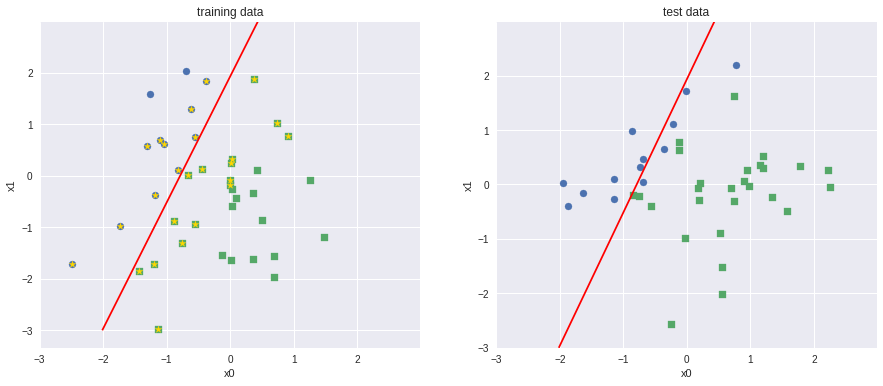

In [29]:
# visualization for train data
fig, (axL, axR) = plt.subplots(ncols=2, figsize=(15, 6))

train_X_p = train_X[train_y == 1]
train_X_n = train_X[train_y == -1]
test_X_p = test_X[test_y == 1]
test_X_n = test_X[test_y == -1]

sv = train_X[last.astype(bool)]

x0range = np.arange(-3, 3, 0.01)
x1range = np.arange(-3, 3, 0.01)
X0, X1 = np.meshgrid(x0range, x1range)
Y = X0 * w[0] + X1 * w[1]
if bias:
  Y += w[2]
axL.set_title('training data')
axL.set_xlabel('x0')
axL.set_ylabel('x1')
axL.contour(X0, X1, Y, [0], colors='red')
axL.scatter(train_X_p[:,0], train_X_p[:,1], marker='o')
axL.scatter(train_X_n[:,0], train_X_n[:,1], marker='s')
axL.scatter(sv[:,0], sv[:,1], marker='*', color='gold')
axR.set_title('test data')
axR.set_xlabel('x0')
axR.set_ylabel('x1')
axR.contour(X0, X1, Y, [0], colors='red')
axR.scatter(test_X_p[:,0], test_X_p[:,1], marker='o')
axR.scatter(test_X_n[:,0], test_X_n[:,1], marker='s')
plt.show()